In [54]:
import pandas as pd
import numpy as np

from collections import OrderedDict, namedtuple
from itertools import product
import time
from IPython.display import display, clear_output
import json

import torch 
from torchvision.transforms import Normalize
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

In [38]:
train_url = "https://raw.githubusercontent.com/wehrley/Kaggle-Digit-Recognizer/master/train.csv"
df_train = pd.read_csv(train_url)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [39]:
test_url = 'https://raw.githubusercontent.com/wehrley/Kaggle-Digit-Recognizer/master/test.csv'
df_test = pd.read_csv(test_url)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [128]:
train_set = df_train[0:29400]
train = torch.tensor(np.array(train_set.iloc[:, 1:]), dtype=torch.torch.float32)
train_labels = torch.tensor(np.array(train_set.iloc[:, 0]), dtype=torch.int64)

val_set = df_train[29400:]
val = torch.tensor(np.array(val_set.iloc[:, 1:]), dtype=torch.float32)
val_labels = torch.tensor(np.array(val_set.iloc[:, 0]), dtype=torch.int64)

In [112]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [113]:
train.shape

torch.Size([29400, 784])

In [114]:
#network1 = nn.Sequential(
#    nn.Linear(in_features=28*28, out_features=10),
#    nn.Tanh())

#networks = {
#    'one_layer': network1, 
#}

params = OrderedDict(
    lr = [0.1, 0.001, 0.00001],
    batch_size = [20, 1000],
    device = ['cuda'],
    weight_decay = [0.0, 1.0, 10.0])
 #   network = list(networks.keys())
#)

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None

       
    def begin_run(self, run, network):
        self.run_start_time = time.time()
        
        self.epoch_count = 0
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        
    def end_run(self):
        self.epoch_count = 0
    
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(train)
        accuracy = self.epoch_num_correct / len(train)

            
        results = OrderedDict()
        results["run"] = self.run_count
        results['epoch'] = self.epoch_count
        results['loss'] = loss
        results['accuracy'] = accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k, v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * 10
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
        
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName): # save in json and csv
        
        pd.DataFrame.from_dict(self.run_data, orient='columns').to_csv(f'{fileName}.csv')
        
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

m = RunManager()
for run in RunBuilder.get_runs(params):
    network = nn.Sequential(nn.Linear(in_features=28*28, out_features=10), nn.Tanh()).to(device)
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)

    m.begin_run(run, network)
    for epoch in range(40):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.end_epoch()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('accuracy', ascending=False)[0:15]

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,1.149362,0.102007,0.944443,0.944443,0.1,20,cuda,0.0
1,1,2,1.149781,0.101224,1.011293,1.970700,0.1,20,cuda,0.0
2,1,3,1.149781,0.101224,0.987362,2.983992,0.1,20,cuda,0.0
3,1,4,1.149781,0.101224,0.920540,3.927471,0.1,20,cuda,0.0


KeyboardInterrupt: 

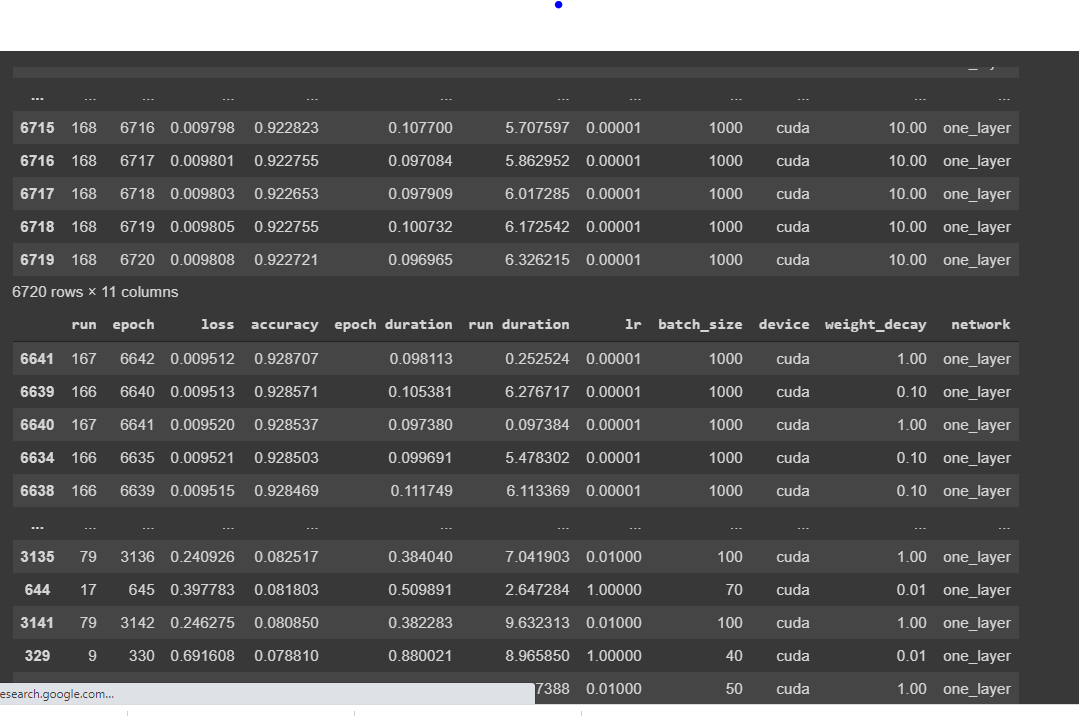

In [50]:
m.save('kaggle_mnist_fully_connected_no_hidden_tanh_v2')

In [115]:
train_labels.shape[0]

29400

In [141]:
len(train)

29400

In [142]:
len(df_train)

42000

In [152]:
t = torch.tensor([[1,2,3],[4,5,6]], dtype=torch.float32)
torch.narrow(t, 1, 1, 2)

tensor([[2., 3.],
        [5., 6.]])

In [153]:
torch.narrow(t, 1, 0, 1)

tensor([[1.],
        [4.]])

# Data Normalization (via Standardization)

In [191]:
df_train_copy = df_train.copy()
df_train_copy = torch.tensor(np.array(df_train_copy), dtype=torch.float32)
pixels_only = torch.narrow(df_train_copy, 1, 1, 784) # start at 1 to 1 +  = 42000 total samples
df_train_copy_mean = pixels_only.sum()/(42000*28*28)
df_train_copy_var = (1 / (42000 * 28 * 28)) * ((pixels_only - df_train_copy_mean)**2).sum()
df_train_copy_std = df_train_copy_var.sqrt()

train_set = df_train_copy[0:29400]
train = torch.narrow(train_set, 1, 1, 784)
train = (train - df_train_copy_mean) / df_train_copy_std
train_labels = torch.narrow(train_set, 1, 0, 1)
train_labels = torch.tensor(train_labels, dtype=torch.int64).squeeze() # they are 2D if you don't squeeze

val_set = df_train_copy[29400:]
val = torch.narrow(val_set, 1, 1, 784)
val = (val - df_train_copy_mean) / df_train_copy_std
val_labels = torch.narrow(val_set, 1, 0, 1)
val_labels = torch.tensor(val_labels, dtype=torch.int64).squeeze() # they are 2D if you don't squeeze

print(df_train_copy_mean, df_train_copy_std, train.mean(), train.std(), val.mean(), val.std())

tensor(33.4089) tensor(78.6929) tensor(-0.0003) tensor(0.9993) tensor(0.0008) tensor(1.0009)


C:\Anaconda\envs\py36_final\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\Anaconda\envs\py36_final\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [192]:
val_labels[0:3]

tensor([3, 2, 7])

In [201]:
batch_size = 20
learning_rate = 0.001
weight_decay = 0.0
epochs = 15

validation_set = val.to(device)
validation_labels = val_labels.to(device) 

model = nn.Sequential(
    nn.Linear(in_features=28*28, out_features=10),
    nn.Tanh(),
    nn.BatchNorm1d(10))


model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
for j in range(epochs):
    num_correct = 0
    val_number_correct = 0
    mini_batches = [train[k:k + batch_size] for k in range(0, train_labels.shape[0], batch_size)]
    mini_labels = [train_labels[k:k + batch_size] for k in range(0, train_labels.shape[0], batch_size)]
    for b in range(0, len(mini_batches)):
        images = mini_batches[b].to(device)
        #print(images.shape)
        labels = mini_labels[b].to(device)
        #print(labels.shape)
        #print(labels.dtype)
        #print(images.dtype)
        preds = model(images)
        loss = F.cross_entropy(preds, labels) # calculate loss
        optimizer.zero_grad() # zero gradients so they can be calculated for this batch
        loss.backward() # calculate gradient of cost wrt weights/biases
        optimizer.step() # update the weights
        num_correct += preds.argmax(dim=1).eq(labels).sum().item()
    with torch.no_grad():
        validation_preds = model(validation_set)
        val_number_correct += validation_preds.argmax(dim=1).eq(validation_labels).sum().item()

    print('Completed epoch: ', j)
    print('Train accuracy: ', num_correct/len(train))
    print('Validation Accuracy: ', val_number_correct/len(validation_set))
    scheduler.step()

Completed epoch:  0
Train accuracy:  0.8203061224489796
Validation Accuracy:  0.900952380952381
Completed epoch:  1
Train accuracy:  0.851530612244898
Validation Accuracy:  0.9076984126984127
Completed epoch:  2
Train accuracy:  0.8651020408163266
Validation Accuracy:  0.9033333333333333
Completed epoch:  3
Train accuracy:  0.8758503401360545
Validation Accuracy:  0.9038888888888889
Completed epoch:  4
Train accuracy:  0.8838775510204082
Validation Accuracy:  0.9065873015873016
Completed epoch:  5
Train accuracy:  0.8996258503401361
Validation Accuracy:  0.9151587301587302
Completed epoch:  6
Train accuracy:  0.9038775510204081
Validation Accuracy:  0.9158730158730158
Completed epoch:  7
Train accuracy:  0.9054761904761904
Validation Accuracy:  0.9169047619047619
Completed epoch:  8
Train accuracy:  0.9068367346938776
Validation Accuracy:  0.917063492063492
Completed epoch:  9
Train accuracy:  0.9079591836734694
Validation Accuracy:  0.9176984126984127
Completed epoch:  10
Train accura

# Training and Validation Accuracies with Fully Connected nn with no hidden layers and a single Tanh Activation 

## VALIDATION: 91.9% TRAINING ACC: 91.1%
- with data normalization via standardization
- batch_size = 20 (batch=10 results in training 90.9% and val 90.3)
- **learning_rate = 0.001 (decaying by 0.1 every 5 epochs boosted performance near 1%)**
- weight_decay = 0 (val acc rapidly stalls at 86.3% with lambda=10)
- epochs = 40
- **with batch norm**



### val 91.3% train 92.0% 
- with data normalization via standardization
- batch_size = 20 (batch=10 results in training 90.9% and val 90.3)
- learning_rate = 0.001 (decaying by 0.1 every 10 epochs
- weight_decay = 0 (val acc rapidly stalls at 86.3% with lambda=10)
- epochs = 40
- **with batch norm**

### val 91.1% train 91.8%
- with data normalization via standardization
- batch_size = 20 (batch=10 results in training 90.9% and val 90.3
- learning_rate = 0.00001
- weight_decay = 0 (val acc rapidly stalls at 86.3% with lambda=10)
- epochs = 120 (70 leads to val/train acc reduction of 0.1 to 0.2
- no batch norm

#### val 90.7% train 91.2%
- no data normalization
- batch_size = 20 (batch=10 results in training 90.9% and val 90.3
- learning_rate = 0.00001
- weight_decay = 10.0
- epochs = 40 (70 doesn't improve)
- no batch norm

## Notes on data normalization
- At first I standardized training and val sets separately and accuracy dropped from 90% to low 80s. Played with lambda and got it to mid to upper 80s, still noticeably below max val acc.


- Then I standardized the entire training set and THEN split it into training val. Accuracy hit max 90.9 on val% (0.2% higher than max with no data normalization. Note, performance with lambda=10 was worse.

15. Check the preprocessing for train/validation/test set
CS231n points out a common pitfall:
“… any preprocessing statistics (e.g. the data mean) must only be computed on the training data, and then applied to the validation/test data. E.g. computing the mean and subtracting it from every image across the entire dataset and then splitting the data into train/val/test splits would be a mistake. “
Also, check for different preprocessing in each sample or batch.

## Note, I believe approach below is wrong for data normalization. You should calculate avg and std over all train samples and then split those into train/val

    train = (train - mean) / std
    print(train.mean(), train.std())

    val_mean = val.sum()/(len(val) * 28 * 28)
    val_var = (1 / (len(val) * 28 * 28)) * ((val - val_mean)**2).sum()
    val_std = val_var.sqrt()
    val = (val - mean) / val_std

# 37 Reasons why your Neural Network is not working
https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607

## I. Dataset Issues
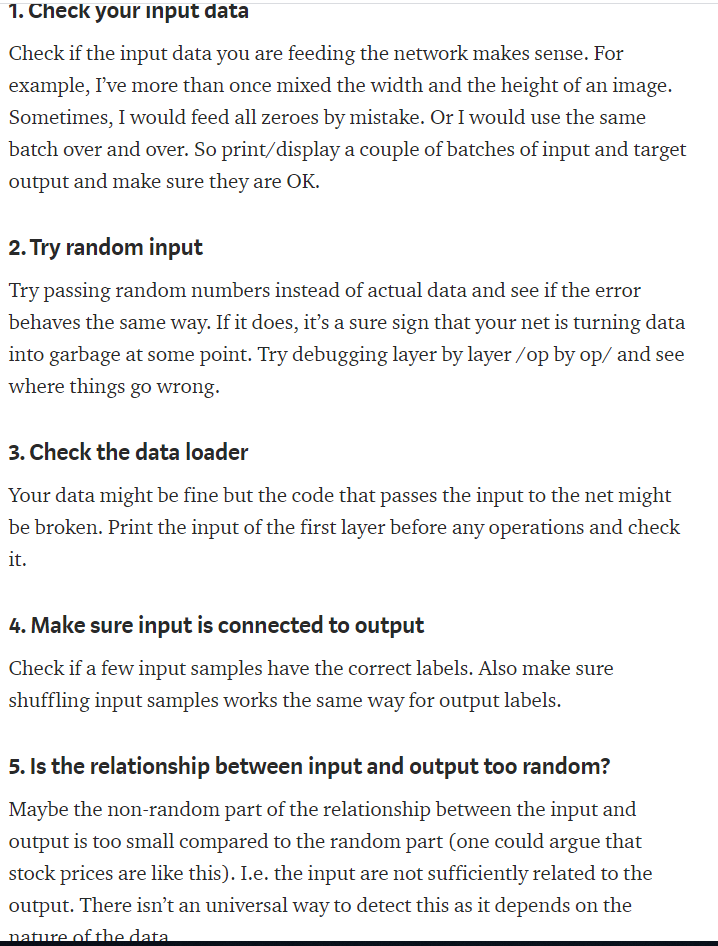

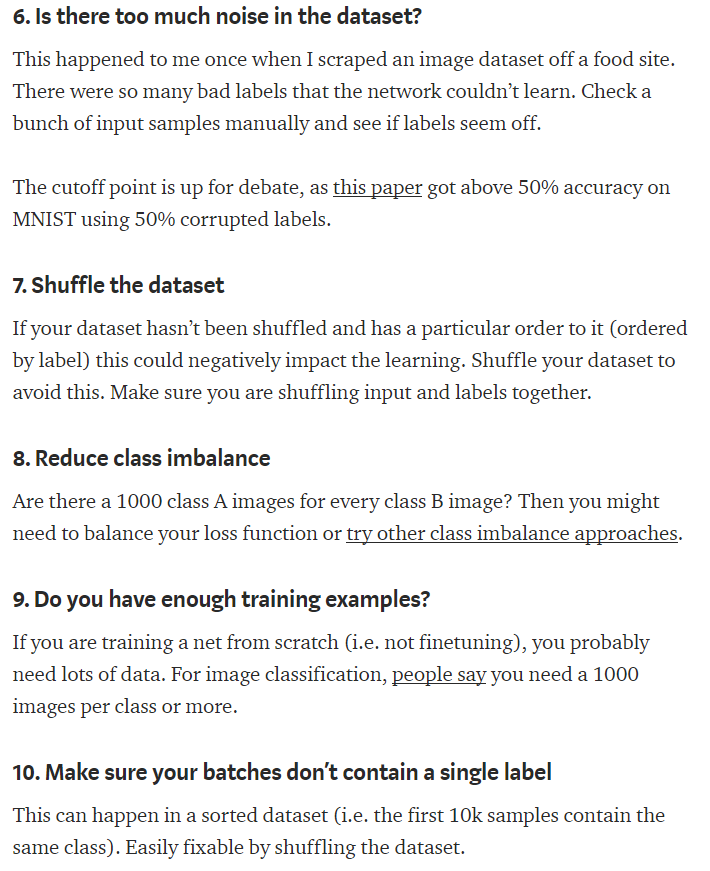

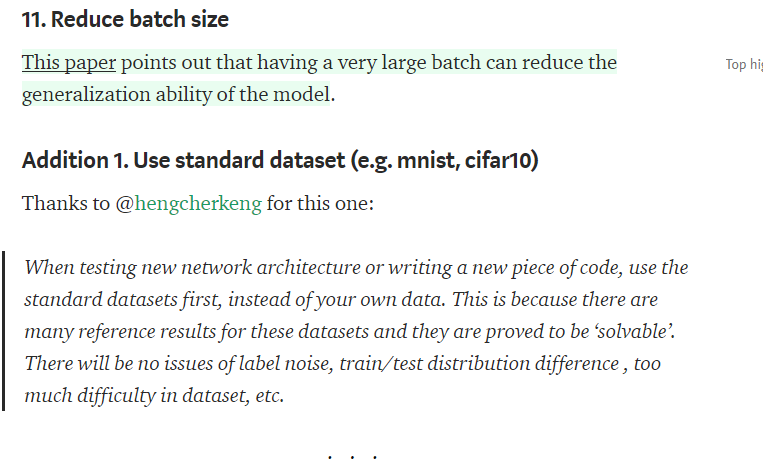

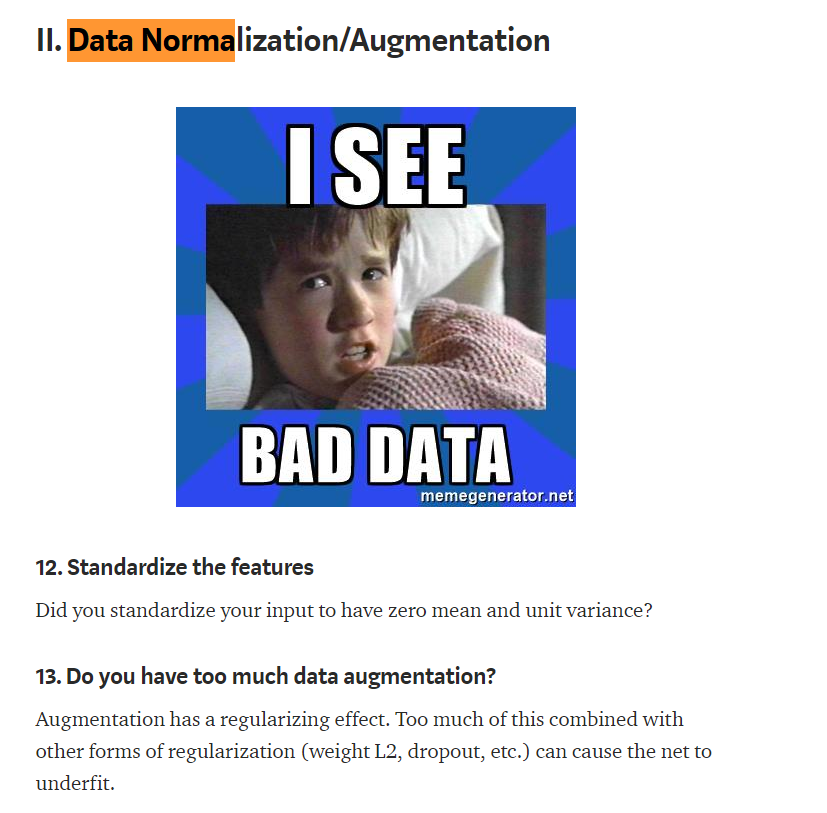

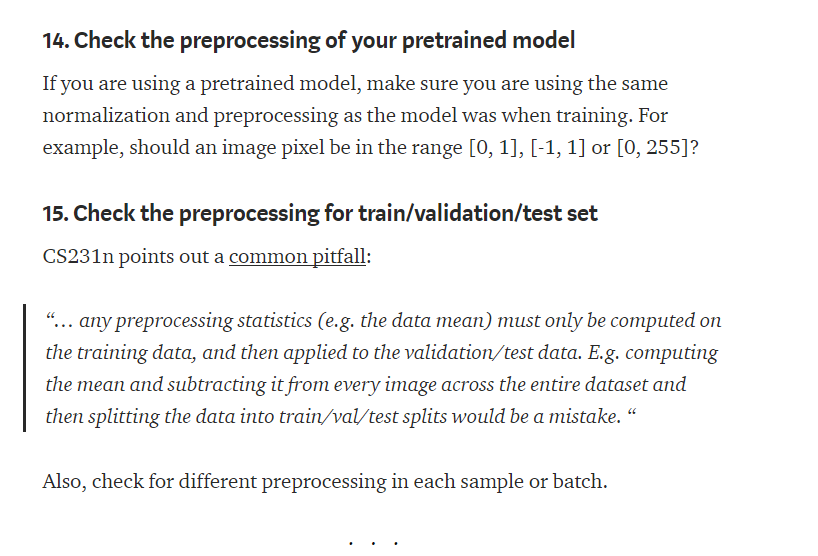

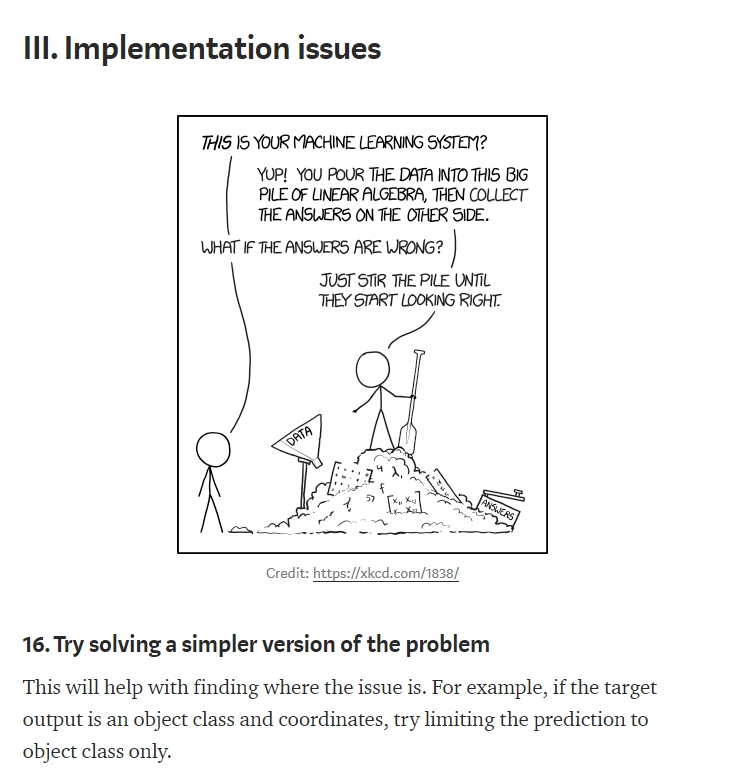

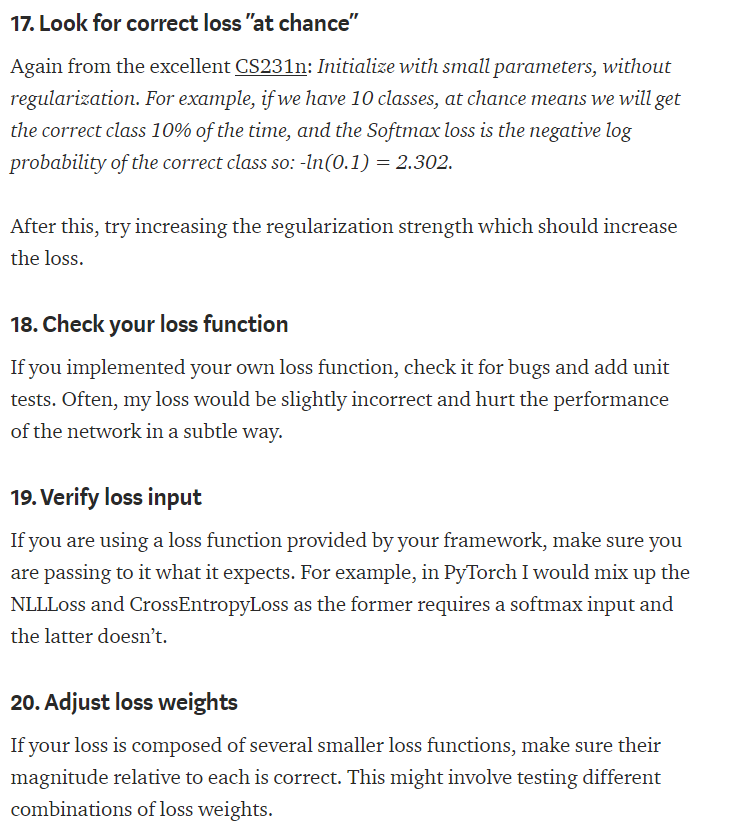

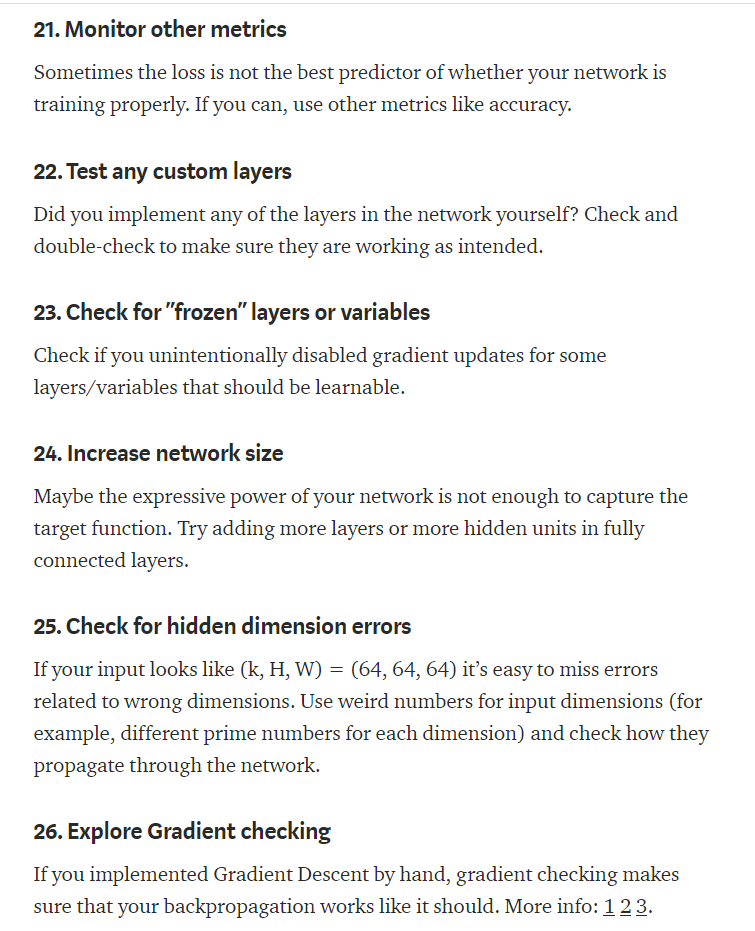

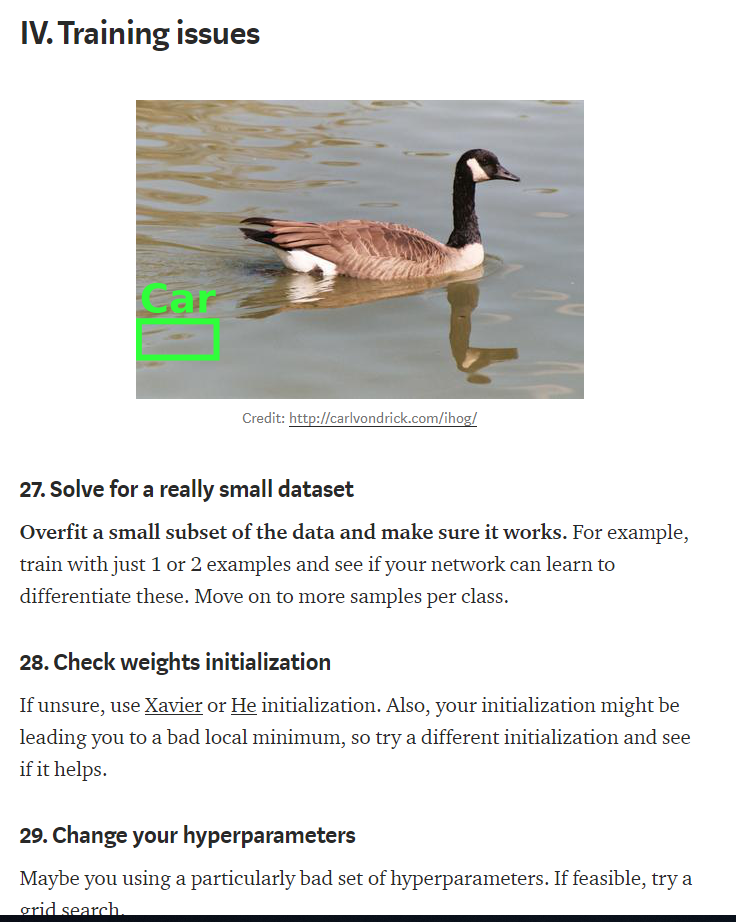

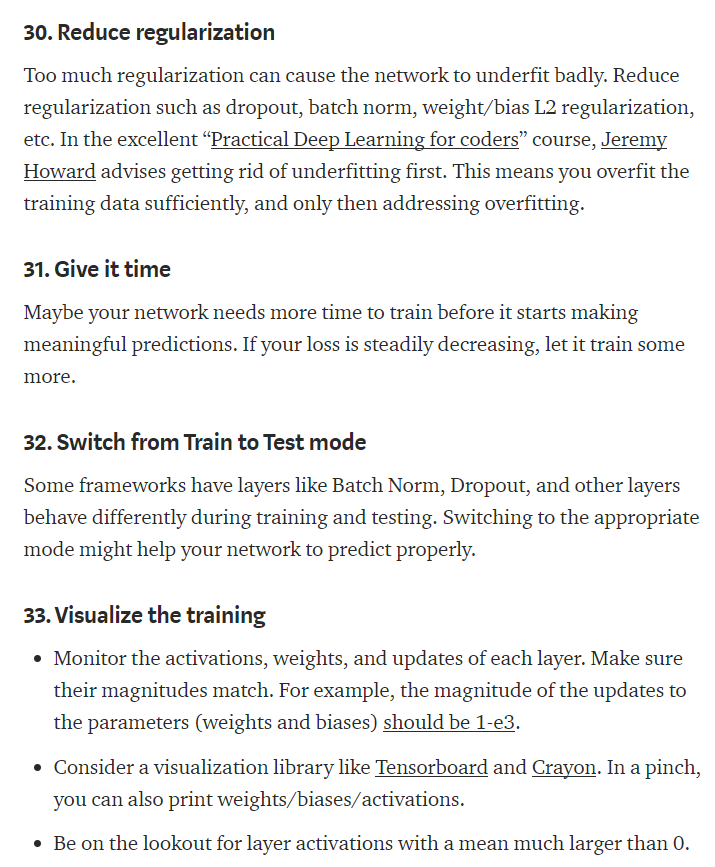

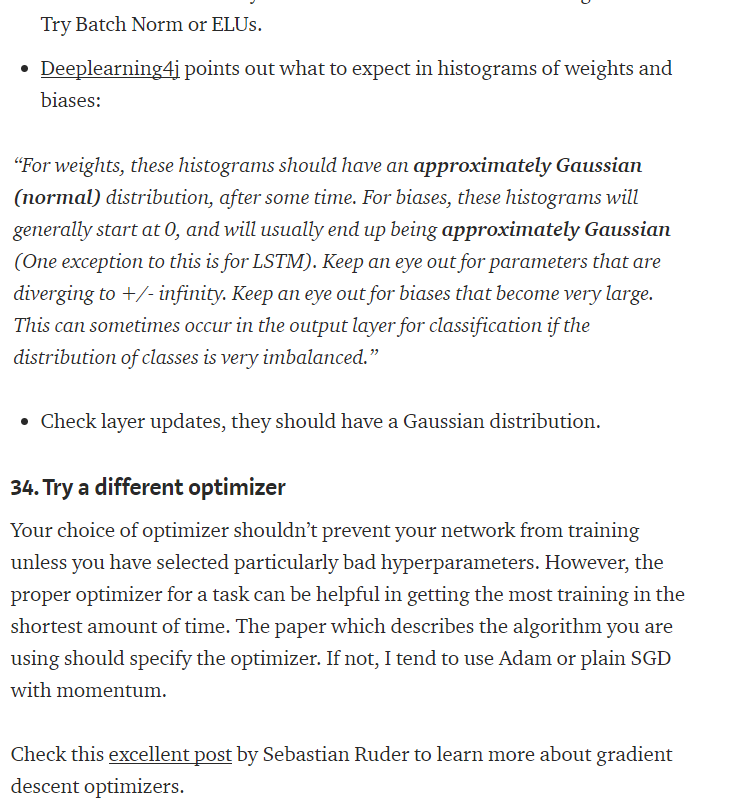

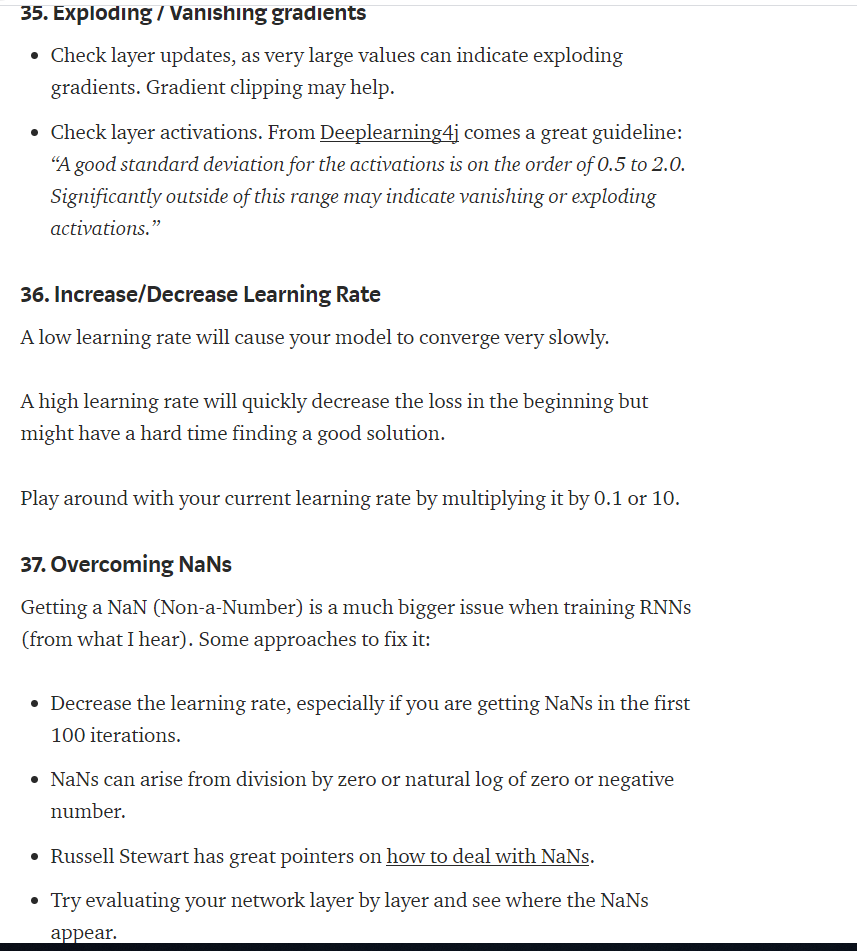

## Machine Learning Mastery 
https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
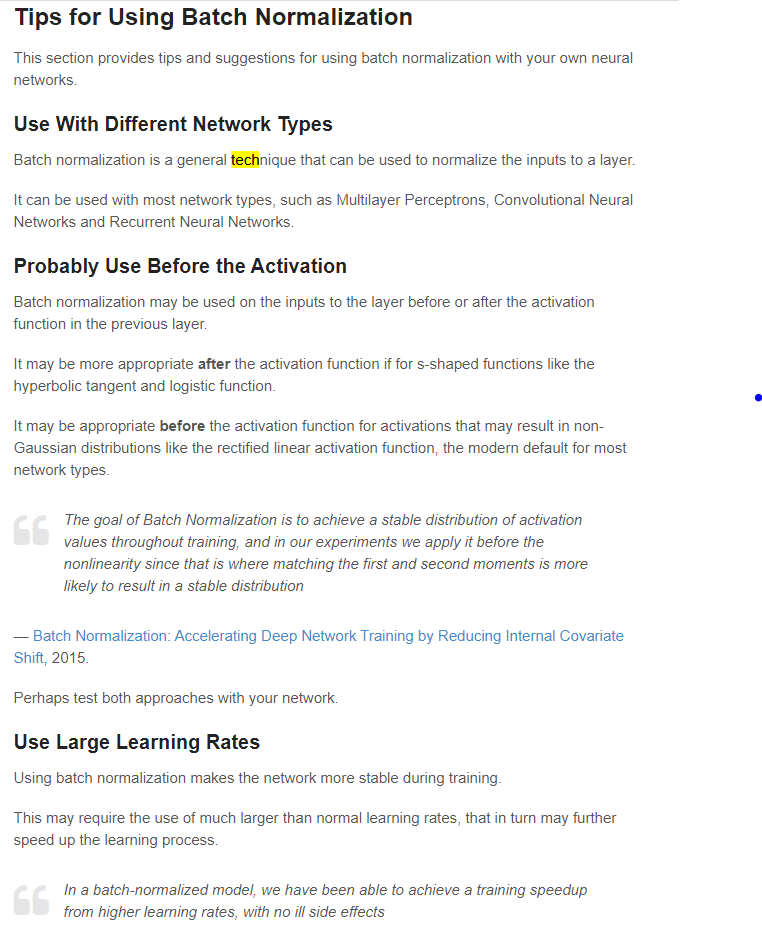